In [1]:
!pip install pandas openpyxl
!pip install pandas xlrd

In [73]:
import pandas as pd
Fuxin_sites = pd.read_excel('Fuxin_Sites.xlsx', engine='openpyxl')
Fuxin_sites.head()

,FID,POINT_X,POINT_Y,Unnamed: 3,Unnamed: 4,"Fuxin survey, Neolithic sites"
0,98,407245.248520,4.671248e+06,NaN,NaN,UTM grid (Zone 51N)
1,99,407248.066810,4.671312e+06,NaN,NaN,NaN
2,100,407253.417065,4.671382e+06,NaN,NaN,NaN
3,4,406461.099184,4.668811e+06,NaN,NaN,NaN
4,97,406963.890081,4.669504e+06,NaN,NaN,NaN


In [75]:
Fuxin_ED = pd.read_excel('Fuxin_environmental_data.xlsx', engine='openpyxl')
Fuxin_ED.head()

,FID,POINT_X,POINT_Y,Crops_distance,Modern built_distance,Foresnts_distance,Slope,Aspect,Land carvature,Elevation,Main_River_Distance
0,0,403810.411558,4665348.528,0.0,0.000000,0.0,0.000000,0.000000,0.00,200,80.889444
1,1,403710.411558,4665448.528,0.0,894.427002,100.0,0.816535,195.255005,-0.64,199,19.261071
2,2,403810.411558,4665448.528,100.0,900.000000,0.0,0.865319,204.444000,-2.56,200,71.678892
3,3,403910.411558,4665448.528,0.0,900.000000,100.0,0.816535,127.875000,0.64,200,165.269779
4,4,404010.411558,4665448.528,0.0,900.000000,200.0,0.871224,170.537994,-2.56,199,263.568679


In [76]:
Fuxin_ED['POINT_X'] = Fuxin_ED['POINT_X'].astype(int)
Fuxin_ED['POINT_Y'] = Fuxin_ED['POINT_Y'].astype(int)
Fuxin_sites['POINT_X'] = Fuxin_sites['POINT_X'].astype(int)
Fuxin_sites['POINT_Y'] = Fuxin_sites['POINT_Y'].astype(int)

In [79]:
import numpy as np
def check_any_distance(point_x, point_y, df1):
    # Calculate distances from this point to all points in df1
    distances = np.sqrt((df1['POINT_X'] - point_x)**2 + (df1['POINT_Y'] - point_y)**2)
    # If any distance is less than 100, return 1, otherwise 0
    return int((distances < 1000).any())

# Apply the logic across all rows in df2
Fuxin_ED['match'] = Fuxin_ED.apply(lambda row: check_any_distance(row['POINT_X'], row['POINT_Y'], Fuxin_sites), axis=1)
Fuxin_ED.head()

,FID,POINT_X,POINT_Y,Crops_distance,Modern built_distance,Foresnts_distance,Slope,Aspect,Land carvature,Elevation,Main_River_Distance,match
0,0,403810,4665348,0.0,0.000000,0.0,0.000000,0.000000,0.00,200,80.889444,0
1,1,403710,4665448,0.0,894.427002,100.0,0.816535,195.255005,-0.64,199,19.261071,0
2,2,403810,4665448,100.0,900.000000,0.0,0.865319,204.444000,-2.56,200,71.678892,0
3,3,403910,4665448,0.0,900.000000,100.0,0.816535,127.875000,0.64,200,165.269779,0
4,4,404010,4665448,0.0,900.000000,200.0,0.871224,170.537994,-2.56,199,263.568679,0


In [80]:
count_ones = Fuxin_ED['match'].sum()
print(f"Number of rows with match == 1: {count_ones}")

Number of rows with match == 1: 5830


In [83]:
Fuxin_ED.drop(columns=['FID', 'POINT_X','POINT_Y'], inplace=True)

In [85]:
Fuxin_ED.head()

,Crops_distance,Modern built_distance,Foresnts_distance,Slope,Aspect,Land carvature,Elevation,Main_River_Distance,match
0,0.0,0.000000,0.0,0.000000,0.000000,0.00,200,80.889444,0
1,0.0,894.427002,100.0,0.816535,195.255005,-0.64,199,19.261071,0
2,100.0,900.000000,0.0,0.865319,204.444000,-2.56,200,71.678892,0
3,0.0,900.000000,100.0,0.816535,127.875000,0.64,200,165.269779,0
4,0.0,900.000000,200.0,0.871224,170.537994,-2.56,199,263.568679,0


In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [89]:
X=Fuxin_ED.drop(columns=['match'])
y=Fuxin_ED['match']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print(pd.Series(y_train_resampled).value_counts())

match
0    4640
1    4640
Name: count, dtype: int64


In [117]:
model = LogisticRegression(class_weight={0: 1, 1: 2},max_iter=100)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', model)
])

In [119]:
pipeline.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(class_weight={0: 1, 1: 2}))])

In [123]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.94      0.43      0.59      3179
           1       0.38      0.93      0.54      1190

    accuracy                           0.56      4369
   macro avg       0.66      0.68      0.56      4369
weighted avg       0.79      0.56      0.57      4369

Accuracy: 0.5639734493018997


In [101]:
coefficients = pipeline.named_steps['logreg'].coef_[0]  # Get the coefficients for a binary classification (1D array)

# Get feature names
feature_names = X_train.columns  #

In [103]:
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by the absolute value of the coefficient to identify the most important features
feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

print(feature_importance)

                 Feature  Coefficient  abs_coefficient
7    Main_River_Distance    -0.950976         0.950976
0         Crops_distance    -0.566248         0.566248
6              Elevation     0.563241         0.563241
2      Foresnts_distance    -0.359826         0.359826
1  Modern built_distance     0.139460         0.139460
4                 Aspect    -0.058205         0.058205
5         Land carvature    -0.030745         0.030745
3                  Slope     0.029668         0.029668


In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [57]:
# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale data (optional with Decision Trees)
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

In [59]:
# Fit the pipeline
pipeline.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('tree',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [61]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(report)

Accuracy: 0.8244449530785076

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      3179
           1       0.64      0.83      0.72      1190

    accuracy                           0.82      4369
   macro avg       0.78      0.83      0.80      4369
weighted avg       0.85      0.82      0.83      4369



In [131]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Create the pipeline with scaler and decision tree
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling features
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Define the hyperparameter grid to search
param_grid = {
    'tree__max_depth': [3, 5, 10, 15, 20],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 5],
    'tree__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPUs
    verbose=1
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print best parameters
print("Best Parameters Found:", grid_search.best_params_)

# Train the Decision Tree with the best parameters on training data
best_pipeline = grid_search.best_estimator_

# Predict using the best pipeline
y_pred = best_pipeline.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(report)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters Found: {'tree__criterion': 'gini', 'tree__max_depth': 15, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      3179
           1       0.59      0.85      0.70      1190

    accuracy                           0.80      4369
   macro avg       0.76      0.82      0.78      4369
weighted avg       0.84      0.80      0.81      4369



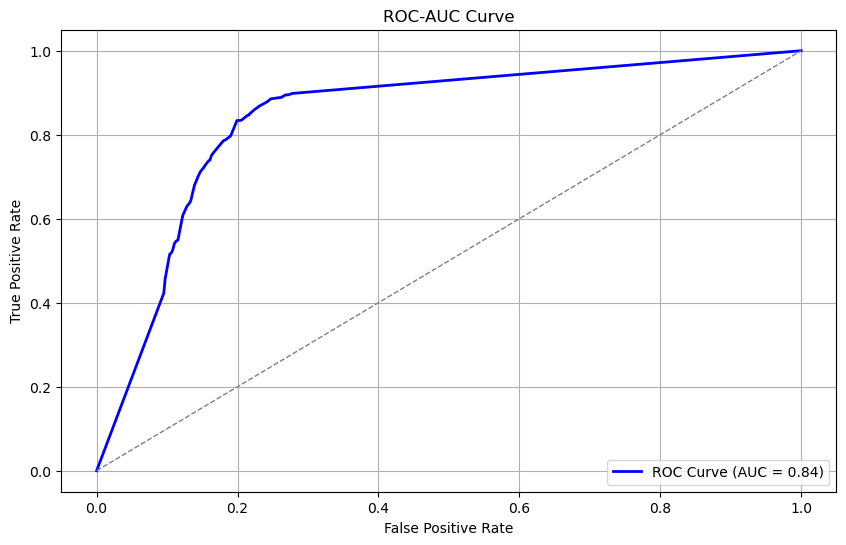

In [133]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (label=1)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plotting the ROC-AUC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
